## Importing the necessary libraries

In [4]:
import os
import cv2
import math
#import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [5]:
!pip install pafy

In [6]:
pip install youtube-dl

     |████████████████████████████████| 1.9 MB 5.3 MB/s 


In [7]:
import pafy

In [8]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [9]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2021-12-30 10:16:53--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  74.6MB/s    in 47s     

2021-12-30 10:17:40 (66.3 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



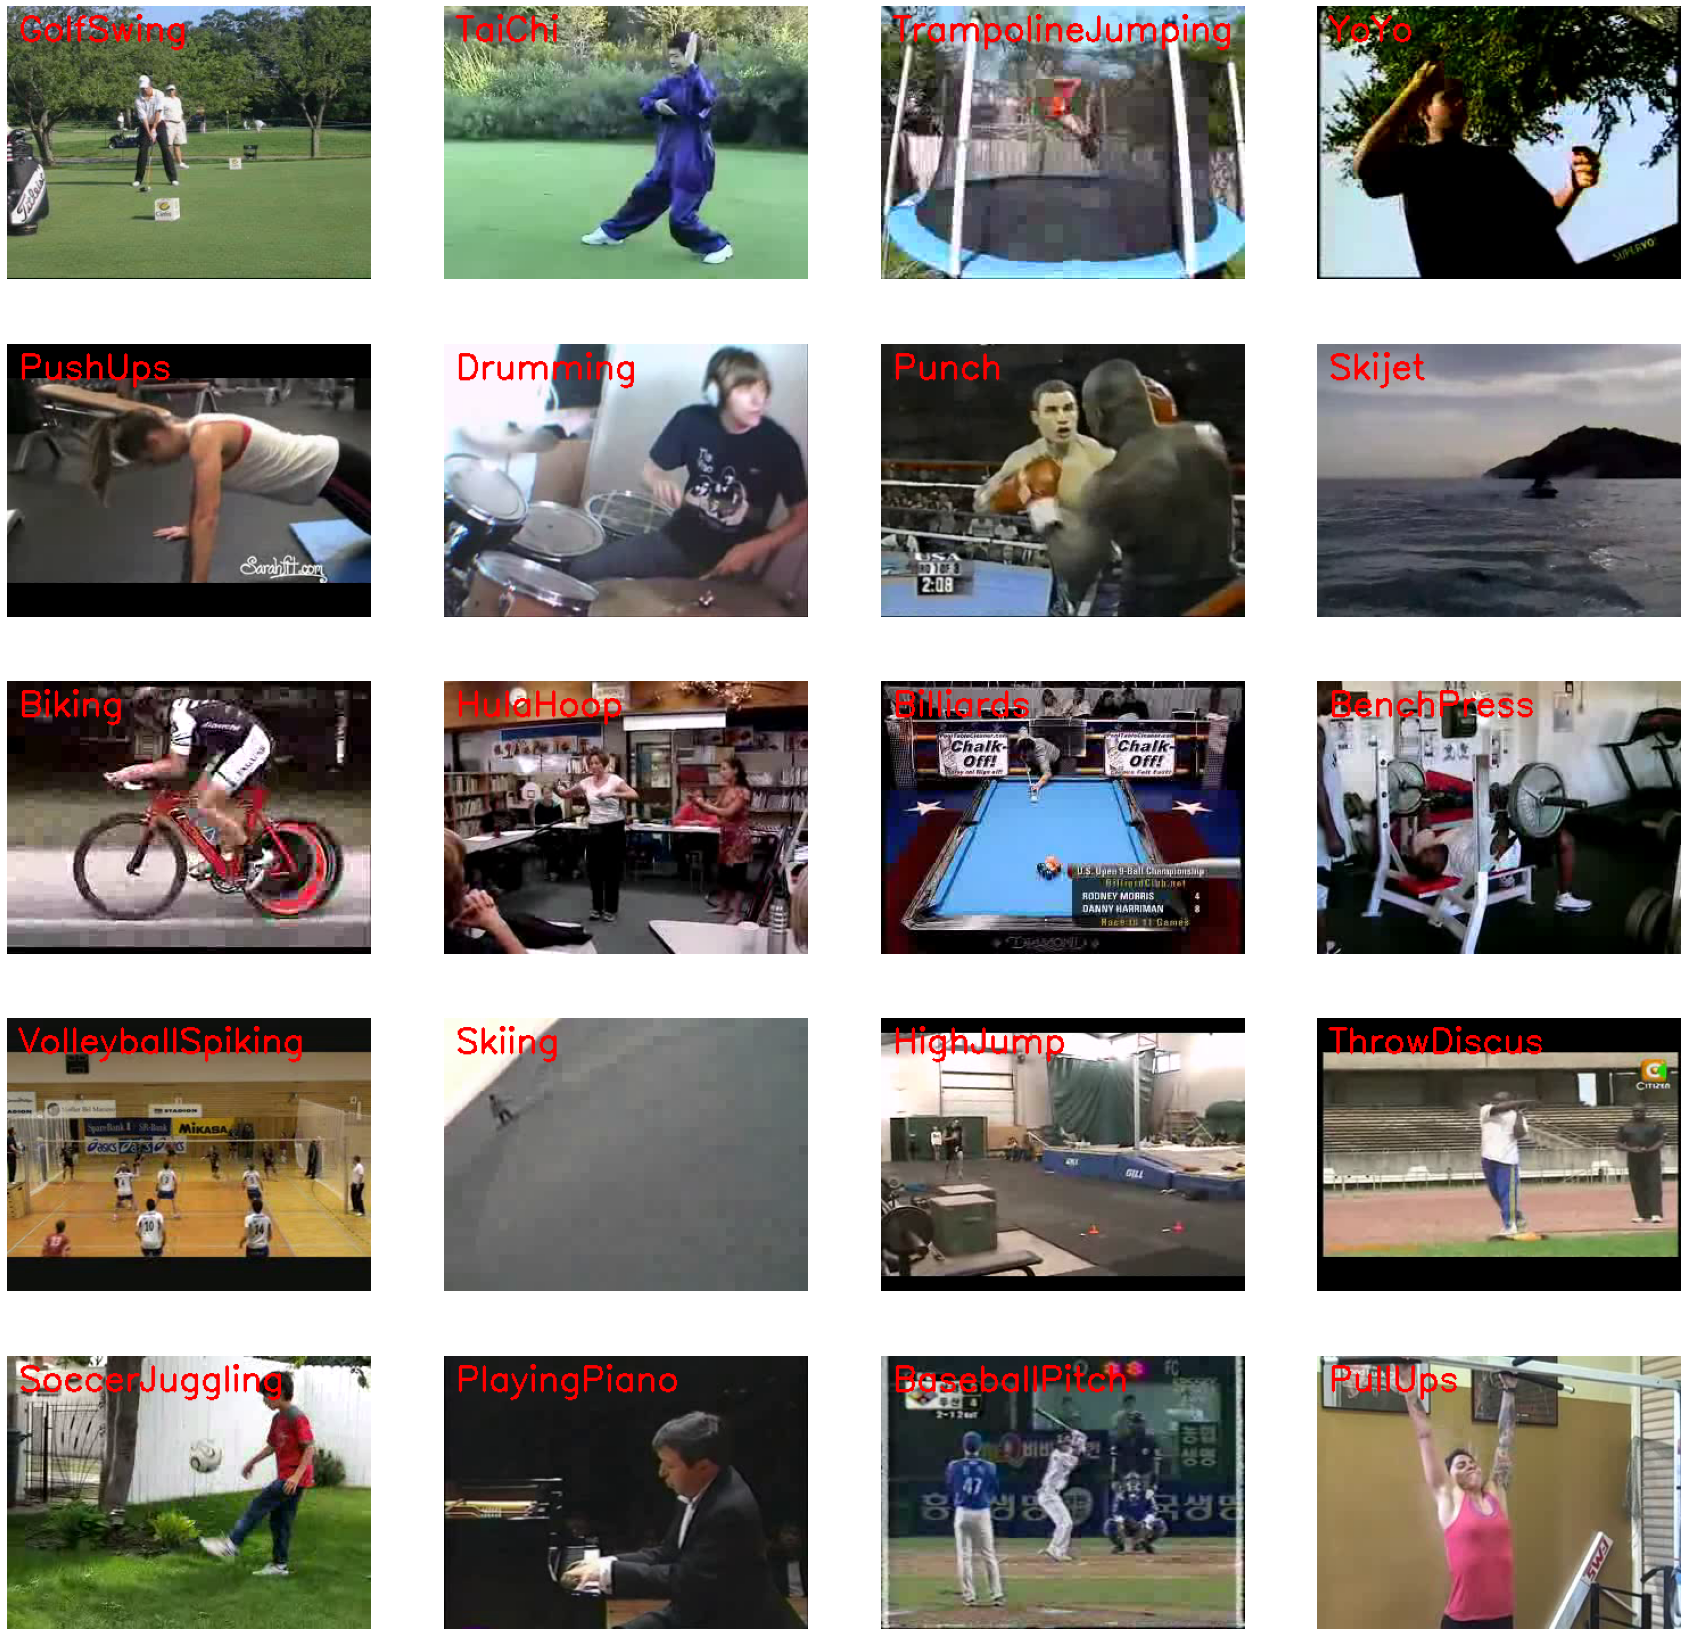

In [10]:
# Creating a MATPLOTLIB figure
plt.figure(figsize=(30,30))

# Getting names of all classes in UCF50
all_classes_names = os.listdir('UCF50')

# Generate a random sample of images each time the cell runs 
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

  # Getting class name using random index
  selected_class_name = all_classes_names[random_index]

  # Getting a list of all the video files present in a class directory
  video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')

  # randomly selecting a vidoe file 
  selected_video_file_name = random.choice(video_files_names_list)

  # Reading the video file using the video capture
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')

  # reading the first frame of the video file
  _, bgr_frame = video_reader.read()

  # closing the videocapture object and releasing all resources
  video_reader.release()
  
  # converting the BGR Frame to RGB Frame
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Adding the class name text on the top of the video frame
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

  # Assigning the frame to a specific position of a subplot
  plt.subplot(5,4, counter)
  plt.imshow(rgb_frame)
  plt.axis('off')

## Preprocessing the dataset

* *image_height* and *image_weight*: This is the size we will resize all frames of the video to, we are doing this to avoid unnecessary computation.
* max_images_per_class: Maximum number of training images allowed for each class.
* dataset_directory: The path of the directory containing the extracted dataset.
* classes_list: These are the list of classes we are going to be training on, we are training on following 4 classess as follows: 
  * tai chi
  * swinging 
  * Horse Racing 
  * Walking with a dog

* The *image_height*, *image_weight*, and *max_images_per_class* constants may be increased for better results, but be warned this will become computationally expensive.

In [11]:
image_height, image_width = 64, 64
max_images_per_class = 5000

dataset_directory = "UCF50"
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

model_output_size = len(classes_list)

## Extracting, Resizing, and Normalizing Frames

In [12]:
def frames_extraction(video_path):
  '''
  custom function that will extract frames from ech video while
  performing othe preprocessing operation like resizing and 
  normnalizing images.

  inputs: a video file path.
  functionality: It reads the video file frame by frame, resizes each 
  frame, normalizes the resized frame, appends the normalized frame into
  a list.
  returns: A list containing the resized, normalized, frames. 

  '''
  # Empty list declared to store video frames
  frames_list = []

  #Reading the video file using VideoCapture
  video_reader = cv2.VideoCapture(video_path)

  # Iterating through Video Frames
  while True:

    # Reading a frame from the video file
    success, frame = video_reader.read()

    # If video frame was not successfully read then break the loop 
    if not success:
      break
    
    # Resize the frame to fixed dimensions
    resized_frame = cv2.resize(frame, (image_height, image_width))

    # Normalize the resized frame by dividing it with 255 so that each
    # pixel value then lies between 0 and 1
    normalised_frame = resized_frame / 255

    # Appending the nomalized frame into the frames list
    frames_list.append(normalised_frame)

    #closing the VideoCapture onject and releasing all resources
    video_reader.release()

    # returning the frames list
    return frames_list

## Dataset Creation

In [13]:
def create_dataset(tempf):
  '''
  This function uses the frame_extraction() function above and creates the final preprocessed dataset
  Functionality:
  1. Iterate through all the classes mentioned in the classes_list
  2. Now for each class iterate through all the video files present in it.
  3. Call the frame_extraction() method on each video file
  4. Add the returned frames to a list calle 'temp_features'
  5. After all videos of a class are processed, randomly select video frames
  (equal to max_images_per_class) and add them to the list called features.
  6. Add labels of the selected videos to the 'labels' list 
  7. After all videos of all classes are processed then return the features and 
  labels as NumPy arrays.

  returens:
    * A list of feature vectors
    * A list of its associated labels

  '''

  # Declaring empty lists to store the features and labels values.
  temp_features = []
  features = []
  labels = []

  # Iterating through all the classes mentioned in the classes list
  for class_index, class_name in enumerate(classes_list):
    print(f'Extracting data of class: {class_name}')

    # Getting the list of vidfeo files present in the specific class name directory
    files_list = os.listdir(os.path.join(dataset_directory, class_name))

    # Iterating through all the files present in the files list 
    for file_name in files_list:
      
      # Construct the complete video path
      video_file_path = os.path.join(dataset_directory, class_name, file_name)

      # Calling the frame_extraction method for every video file path
      frames = frames_extraction(video_file_path)

      #Appending the frames to a temporary list
      temp_features.extend(frames)
      tempf.extend(temp_features)
      
    # Adding rendomly selected frames to the features list    
    features.extend(random.sample(tempf, max_images_per_class))

    # Adding fixed number of labels to the labels list 
    labels.extend([class_index] * max_images_per_class)

    # Emptying the temp_features list so it can be reused to store all frames of the next class
    temp_features.clear()
    tempf.clear()

    # Converting the features and lanels lists to numpy arrays
  features = np.asarray(features)
  labels = np.array(labels)

  return features, labels

In [14]:
tempf = []
features, labels = create_dataset(tempf)

Extracting data of class: WalkingWithDog
Extracting data of class: TaiChi
Extracting data of class: Swing
Extracting data of class: HorseRace


## Converting class labels to one-hot-encoded vectors

In [15]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## Splitting the data into Train and Test Sets.

As, we have two numpy arrays, one containing all images. The second one contains all class labels in one hot encoded format. It's time to split the data to create the training and testing dataset. Shuffling will be done beforehand.

In [16]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

## Constructing the Model

As a baseline model, a CNN model will be created for classification with CNN layers, later on I will move to single frame CNN and CNN-RNN model.

In [17]:
def create_model():

  # Model will be sequential
  model = Sequential()

  # Defining the Model Architechture
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", input_shape = (image_height, image_width, 3)))
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(model_output_size, activation = 'softmax'))


  # Printing the models summary
  model.summary()

  return model


# Calling the create_model method
model = create_model()

print("Model Created Sucessfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

## Checking Models's Architecture

Using **plot_model** funtion, the clear diagram of the model architecture will be displayed. This visualization approach will help to visualize the next complex architectures.

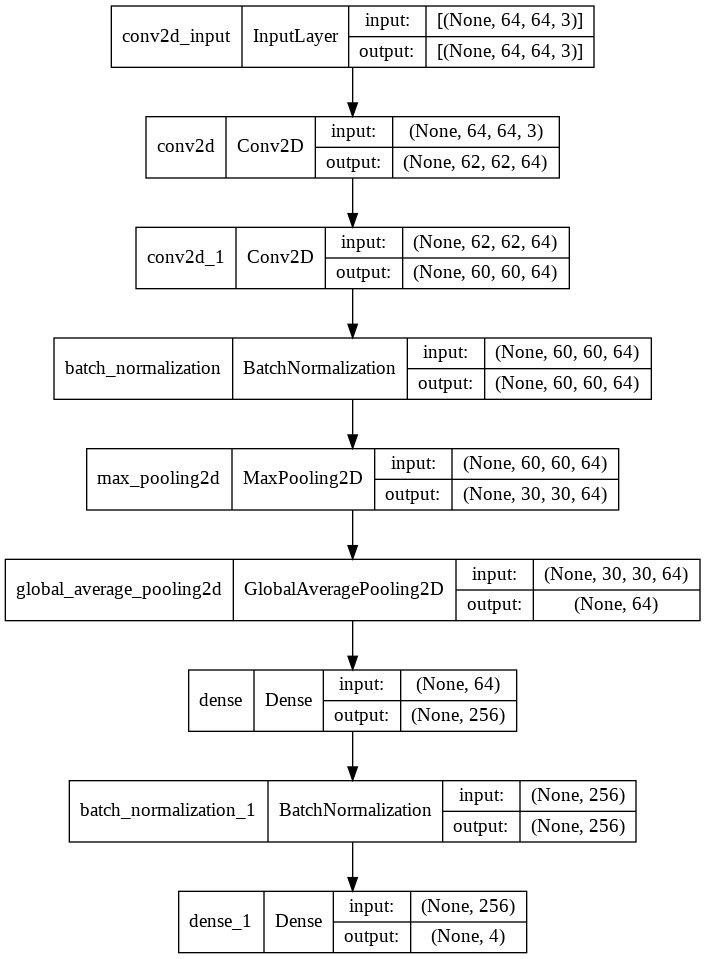

In [18]:
plot_model(model, to_file = "Model_Architecture_Diagram.png", show_shapes = True, show_layer_names = True)

## Compile and Train the Model

In [19]:
# Adding early stopping callbacks
early_stopping_callback = EarlyStopping(monitor = 'val_loss',
                                        patience = 15,
                                        mode = 'min',
                                        restore_best_weights = True 
                                        )

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

# Starting Training
model_training_history = model.fit(x = features_train, y = labels_train,
                                    epochs = 15, batch_size = 4,
                                    shuffle = True, validation_split = 0.2,
                                    callbacks = [early_stopping_callback])

Epoch 1/15
3200/3200 [==============================] - 66s 17ms/step - loss: 0.9357 - accuracy: 0.6117 - val_loss: 0.9047 - val_accuracy: 0.6544
Epoch 2/15
3200/3200 [==============================] - 50s 16ms/step - loss: 0.5322 - accuracy: 0.8015 - val_loss: 0.2524 - val_accuracy: 0.9337
Epoch 3/15
3200/3200 [==============================] - 48s 15ms/step - loss: 0.3460 - accuracy: 0.8766 - val_loss: 0.6866 - val_accuracy: 0.7675
Epoch 4/15
3200/3200 [==============================] - 49s 15ms/step - loss: 0.2671 - accuracy: 0.9087 - val_loss: 1.4286 - val_accuracy: 0.6762
Epoch 5/15
3200/3200 [==============================] - 49s 15ms/step - loss: 0.2313 - accuracy: 0.9230 - val_loss: 0.3745 - val_accuracy: 0.8706
Epoch 6/15
3200/3200 [==============================] - 50s 16ms/step - loss: 0.1960 - accuracy: 0.9373 - val_loss: 0.3233 - val_accuracy: 0.8866
Epoch 7/15
3200/3200 [==============================] - 51s 16ms/step - loss: 0.1742 - accuracy: 0.9430 - val_loss: 0.0444 -

## Evaluating the Trained Model

In [20]:
model_evaluation_history = model.evaluate(features_test, labels_test)

125/125 [==============================] - 2s 13ms/step - loss: 0.0202 - accuracy: 0.9962


## Saving the Model

In [21]:
# Creating a useful name for our model
date_time_format = '%Y_%m_%d_%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model--Date_Time_{current_date_time_string}--Loss_{model_evaluation_loss}--Accuracy_{model_evaluation_accuracy}.h5'

# Saving the Model
model.save(model_name)

## Plotting Model's Loss and Accuracy Curves

In [22]:
def plot_metric(metric_name_1, metric_name_2, plot_name):

  # Getting metric values metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Contructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Adding title to the plot
  plt.legend()

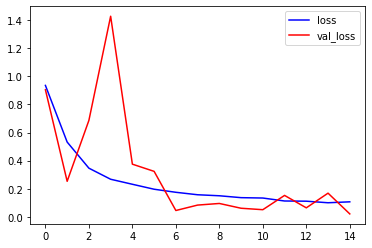

In [23]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

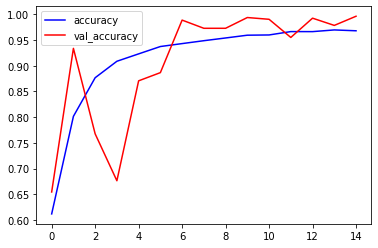

In [24]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation')

## Function to Predict on Live Videos Using Moving Average

This function will perform predictions on live videos using *moving_average*. I can either pass in videos saved on disk or use a webcam. If we set *window_size* hyperparameter to 1, this function will behave like a normal classifier to predict video frames.

In [25]:
def predict_on_live_video(video_file_path, output_file_path, window_size):
# **Readers' attributes aren't accessible from the video clip, showing oserror and indexoutof range error**
  # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality
  predicted_labels_probabilities_deque = deque(maxlen = window_size)

  # Reading the video file using VideoCapture object
  video_reader = cv2.VideoCapture(video_file_path)

  # Getting the width and height of the video
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Writing the Overlayed Video Files Using the VideoWriter Obejct
  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

  while True:

    # Reading the Frame
    status, frame = video_reader.read()

    if not status:
      break

    # Resize the Frame to fixed Dimensions
    resized_frame = cv2.resize(frame, (image_height, image_width))

    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255

    # Passing the image normalized frame to the model and receiving predicted probabilities
    predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

    # Appending predicted label probabilities to the deque object
    predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

    # Assuring that the Deque is completely filled before starting the averaging process
    if len(predicted_labels_probabilities_deque) == window_size:
      # Converting predicted labels probabilities deque into numoy array
      predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

      # Calculating average of Predicted labels probabilities column wise
      predicted_labels_probabilities_avg = predicted_labels_probabilities_np.mean(axis=0)

      # Converting the predicted probabilities into labels by returning the index of the maximum value
      predicted_label = np.argmax(predicted_labels_probabilities_avg)

      # Accessing the classname using predicted label
      predicted_class_name = classes_list[predicted_label]

      # Overlaying the class name with predicted label
      predicted_class_name = classes_list[predicted_label]

      # Overlaying the class name text on the top of the frame
      cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

      # Writing the frame
      video_writer.write(frame)

      # closing the VideoCapture and VideoWrited objects and releasing all resources held by them
      video_reader.release()
      video_writer.release()

In [26]:
# Calling the predict_on_live_video method to start the prediction and rolling average process
#predict_on_live_video('/content/Horse Racing.mp4', '/content/Output Folder', 25)
# Play video file in the notebook
#VideoFileClip('/content/').ipython_display(width=700)

# Using Single-Frame CNN Method


In [27]:
def make_average_predictions(video_file_path, predictions_frames_count):
  '''
  input: Its takes 'n' frames from the entire video and make predictions. 
  This function will average the predictions of those n frames to give us the final activity class for that video.
  I will set the value of n using the predictions_frames_count variable.
  '''

  # Initializing the NumPy array which will store prediction probabilities
  predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

  # Reading the Video File using thr VideoCapture Object
  video_reader = cv2.VideoCapture(video_file_path)

  # Getting the total frames present in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculating the number of frames to skip before reading a frame
  skip_frames_window = video_frames_count // predictions_frames_count

  for frame_counter in range(predictions_frames_count):

    # Setting Frame Position
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # Reading the frame
    _, frame = video_reader.read()

    # Resize the frame to fixed dimensions
    resized_frame = cv2.resize(frame, (image_height, image_width))

    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255

    # Passing the image normalized frame to the model and receiving predicted probabilities.
    predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis=0))[0]

    # Appending predicted label probabilities to the deque object
    predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities
  
  # Calculating the Average Predicted Labels Probabilitoes
  predicted_labels_probabilities_avg = predicted_labels_probabilities_np.mean(axis = 0)

  # Sorting the averaged predicted labels probabilities
  predicted_labels_probabilities_avg_sorted_indexes = np.argsort(predicted_labels_probabilities_avg)[::-1]

  # Iterating over all average predicted label probabilities
  for predicted_label in predicted_labels_probabilities_avg_sorted_indexes:

    # Accessing the class name using predicted label
    predicted_class_name = classes_list[predicted_label]

    # Accessing the averaged probabilities using predicted label
    predicted_probability = predicted_labels_probabilities_avg[predicted_label]

    print(f'Class Name: {predicted_class_name}; Average Probability: {(predicted_probability*100):.2}')

  # Closing the VideoCapture object and releasing all resources held by it.
  video_reader.release()    

In [30]:
make_average_predictions('/content/yt1s.com - Tai Chi_360p.mp4', 50)
#VideoFileClip('/content/Horse Racing.mp4').ipython_display(width=700)

Class Name: TaiChi; Average Probability: 1e+02
Class Name: Swing; Average Probability: 0.01
Class Name: HorseRace; Average Probability: 0.0024
Class Name: WalkingWithDog; Average Probability: 3e-05


# Using CNN-RNN Model